In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [2]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0811'):
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


NameError: name 'input_bucket' is not defined

In [4]:
churn_metric.head()

,Unnamed: 0,genre,medal,churn_per_hr_person
0,0,action,Platinum,-0.014955
1,1,action,Gold,-0.038102
2,2,action,Silver,-0.010055
3,3,action,Bronze,-0.022941
4,4,comedy,Platinum,-0.011701


In [5]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
# hours_viewed = run_query('''SELECT * FROM max_dev.workspace.user_title_hours_watched_crossvalidation''')

In [7]:
hours_viewed = pd.read_csv('validation_data.csv')

In [8]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal']]

In [9]:
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre'}, inplace = True)

In [10]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

In [11]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','churn_per_hr_person']], on = ['genre','medal'], how = 'left')

In [12]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [13]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0.015]

# Allocate the 60-Day Churn to monthly

## First 60 Allocation

In [14]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 60, 1)]

In [15]:
hours_viewed_thresh['key'] = 1
dt_df['key'] = 1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [16]:
hours_viewed_60d = hours_viewed_thresh.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_60d['request_date'] = pd.to_datetime(hours_viewed_60d['offering_start_date']) \
                                    + pd.to_timedelta(hours_viewed_60d['days_on_hbo_max'], unit='D')

hours_viewed_60d['change_in_churn'] = hours_viewed_60d['change_in_churn_60d']/60

## After 60 Day Allocation

In [17]:
ever_green_titles = pd.read_csv('ever_green_titles.csv')

In [18]:
ever_green_titles.head()

,Unnamed: 0,title_name,title_id,season_number,match_id,offering_start_date,ahvr,ahvr_90
0,5892,Injustice,GYbvoqgoeYawYwwEAAAAN,0,GYbvoqgoeYawYwwEAAAAN,2022-01-17,0.236977,0.593506
1,5249,Red 2,GYOjdCwdKNsI-wgEAAAZc,0,GYOjdCwdKNsI-wgEAAAZc,2022-02-01,0.027843,0.052037
2,3698,Misery,GXrHsBAPxLomBSgEAAAB4,0,GXrHsBAPxLomBSgEAAAB4,2020-06-01,0.018080,0.027320
3,3296,Ella Enchanted,GXoTAXgmV2ZCtwwEAAACI,0,GXoTAXgmV2ZCtwwEAAACI,2020-05-27,0.017993,0.026021
4,3198,The Hangover Part II,GXnjwZgr15aFYqQEAAAbj,0,GXnjwZgr15aFYqQEAAAbj,2020-05-27,0.029151,0.045031


In [19]:
len(ever_green_titles.title_id.unique())

62

In [20]:
len(hours_viewed_thresh.title_id.unique())

753

In [21]:
ever_green_titles.sort_values(by = ['title_name']).title_name.unique()

array(['2 Fast 2 Furious', 'Along Came Polly', 'American Pie',
       'American Psycho', 'Annabelle Comes Home', 'Bad Education',
       'Batman: Assault on Arkham', 'Batman: Under the Red Hood',
       'Big Little Lies', 'Contraband', 'Cowboys & Aliens',
       'Curb Your Enthusiasm', 'Downton Abbey',
       "Dr. Seuss' How the Grinch Stole Christmas", 'Ella Enchanted',
       'Euphoria', 'Fight Club', 'Friday After Next', 'Friends',
       'Full Metal Jacket', 'G.I. Joe: The Rise of Cobra',
       'Game of Thrones', 'Godzilla: King of the Monsters', 'Good Boys',
       'Hall Pass', 'How to Lose a Guy in 10 Days',
       'Ice Age: Continental Drift', 'Injustice',
       'Justice League Dark: Apokolips War',
       'Justice League vs the Fatal Five',
       'Justice League vs. Teen Titans',
       'Justice League: Crisis on Two Earths', 'Justice League: Doom',
       'Justice League: Gods and Monsters',
       'Justice League: The Flashpoint Paradox',
       'Justice League: Throne of 

In [22]:
ever_green_title_id = ever_green_titles.title_id.unique()

In [23]:
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [24]:
from scipy.optimize import curve_fit

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Matplotlib is building the font cache; this may take a moment.


In [26]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = [0, 0.8, 5]
y = [1, 0.1, 0.0001]

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [27]:
x1 = pd.Series(np.arange(0,5,0.1))
y1 = func(x1, *popt)

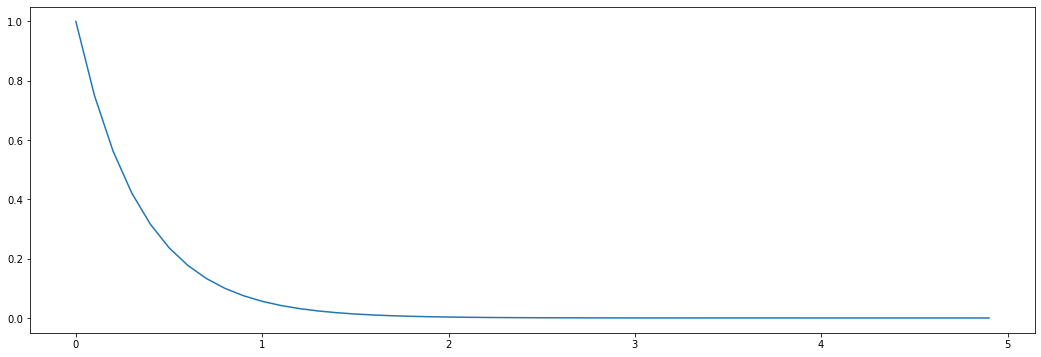

In [28]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x1, y1)
plt.show()

In [29]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max']/365, *popt)
dt_df['key'] = 1

In [30]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)]

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/60*hours_viewed_decay_norm['factor']

hours_viewed_decay_norm['days_on_hbo_max'] = hours_viewed_decay_norm['days_on_hbo_max']+60

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']


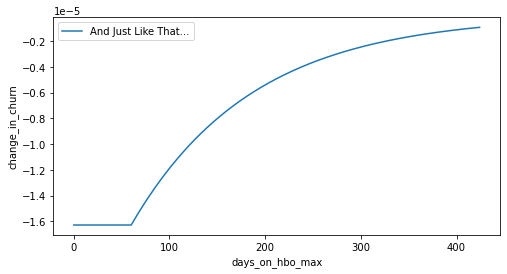

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]],
                axis = 0)
plot_df = test[test['title_name'] == 'And Just Like That...']
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


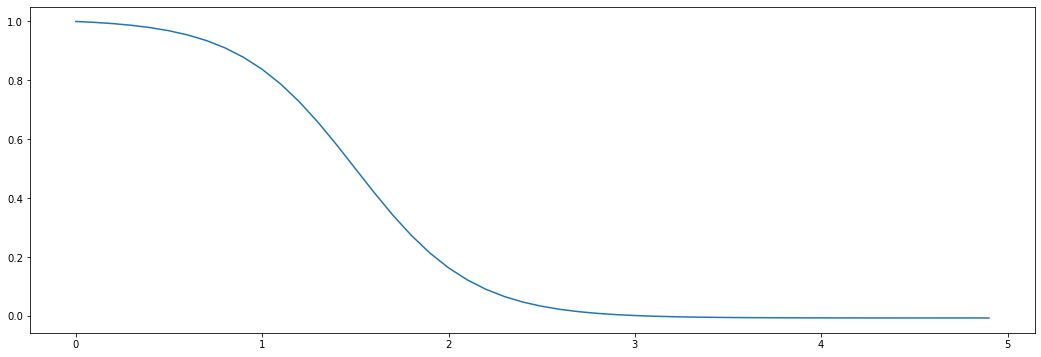

In [32]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [33]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


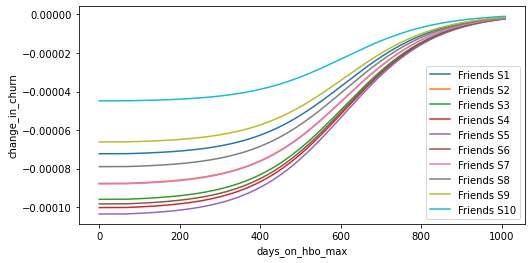

In [34]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [32]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60

hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


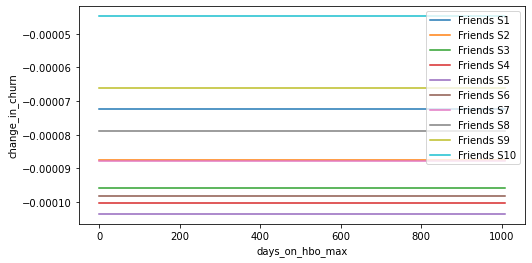

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

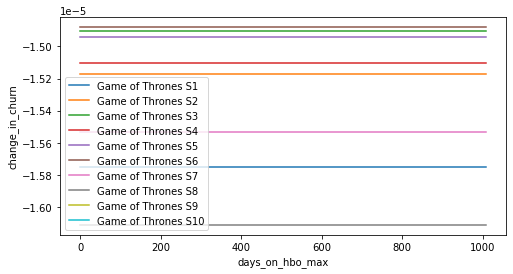

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Game of Thrones') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Game of Thrones S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [35]:
data = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [36]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [37]:
# data.groupby(['date_month']).change_in_churn.sum().reset_index().sort_values(by = ['date_month'])

In [38]:
data[data['date_month'] == '2022-09'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn
104,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,7725,-0.012441
61,Euphoria,GXKN_xQX5csPDwwEAAABj,2,7455,-0.007225
70,Free Guy,GYdYmPQZFO7eZGAEAAAAT,0,6135,-0.005727
110,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,735,-0.004017
76,Friends,GXdbR_gOXWJuAuwEAACVH,5,25245,-0.003105
75,Friends,GXdbR_gOXWJuAuwEAACVH,4,25245,-0.003005
77,Friends,GXdbR_gOXWJuAuwEAACVH,6,25245,-0.002948
74,Friends,GXdbR_gOXWJuAuwEAACVH,3,25245,-0.002877
114,Injustice,GYbvoqgoeYawYwwEAAAAN,0,7245,-0.002718
133,Kong: Skull Island,GX-nzMwc-EaCFpgEAAAMh,0,18675,-0.002690


In [39]:
# data[(data['request_date'] == '2023-03-01')
#     &(data['title_name'] == 'Friends')].sort_values(by = ['change_in_churn']).head(20)

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [41]:
churn_genpop = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
and SUB_MONTH >1
group by 1
order by 1
''')

In [42]:
churn_genpop_tenure = run_query('''
select
     dt.start_date as date_month, sub_month as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [43]:
churn_exclude_t1 = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
AND SUB_MONTH > 1
group by 1
order by 1
''')

In [44]:
churn_genpop.head()

,date_month,churns,total_subs,churn_rate
0,2020-06-01,9,84,0.107143
1,2020-07-01,2125,31493,0.067475
2,2020-08-01,77090,794407,0.097041
3,2020-09-01,92234,1014273,0.090936
4,2020-10-01,107861,1230141,0.087682


In [45]:
churn_genpop_tenure[churn_genpop_tenure['date_month'].astype(str) == '2023-02-01']

,date_month,tenure,churns,total_subs,churn_rate
694,2023-02-01,1,136192,638817,0.213194
695,2023-02-01,2,70790,443055,0.159777
696,2023-02-01,3,40838,317982,0.128429
697,2023-02-01,4,29389,258151,0.113844
698,2023-02-01,5,31783,311660,0.101980
699,2023-02-01,6,30715,361030,0.085076
700,2023-02-01,7,14550,188747,0.077087
701,2023-02-01,8,12738,175350,0.072643
702,2023-02-01,9,11868,174699,0.067934
703,2023-02-01,10,12831,200222,0.064084


In [46]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

In [57]:
aggregated_churn.head()

,date_month,change_in_churn
20,2022-01-01,-0.205097
21,2022-02-01,-0.221712
22,2022-03-01,-0.262035
23,2022-04-01,-0.229062
24,2022-05-01,-0.210834


In [56]:
### 
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

In [58]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [59]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [60]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [61]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [62]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,genpop_churn,churn_exclude_t1,change_in_churn
0,2022-01-01,0.246877,0.153950,0.116810,0.070083,0.096157,0.090982,0.065835,0.061977,0.065632,...,0.022597,0.017149,0.018279,0.043137,0.045375,0.038674,0.031128,0.063140,0.063128,-0.205097
1,2022-02-01,0.193788,0.145940,0.113014,0.091689,0.057784,0.080081,0.076978,0.059083,0.058303,...,0.028064,0.028685,0.025247,0.022683,0.032904,0.043210,0.029851,0.063184,0.063168,-0.221712
2,2022-03-01,0.247388,0.149733,0.118082,0.092952,0.077830,0.058313,0.069130,0.067989,0.050013,...,0.025607,0.023833,0.020620,0.015801,0.017527,0.030667,0.025735,0.063757,0.063743,-0.262035
3,2022-04-01,0.251883,0.177070,0.120366,0.104576,0.085535,0.071325,0.049767,0.067125,0.064703,...,0.030525,0.026052,0.023691,0.020682,0.015332,0.016283,0.027510,0.063942,0.063927,-0.229062
4,2022-05-01,0.250285,0.160922,0.131262,0.095022,0.085187,0.072601,0.062594,0.042802,0.060010,...,0.027141,0.029339,0.024367,0.021946,0.018843,0.014729,0.016480,0.057086,0.057072,-0.210834


In [63]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [64]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [65]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [66]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)
# 0.819

,change_in_churn
dummy_value,-1.000000
churn_exclude_t1,-0.787265
1,-0.111345
23,0.080848
2,0.126000
genpop_churn,0.140112
24,0.188691
11,0.298391
10,0.316234
12,0.441068


<AxesSubplot:>

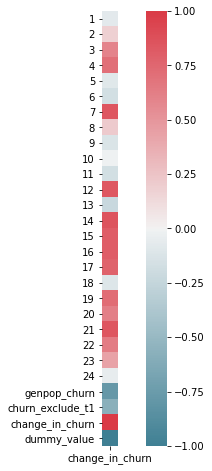

In [117]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

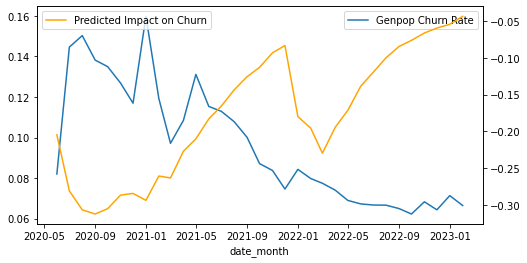

In [270]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend()
ax2.legend()

plt.show()

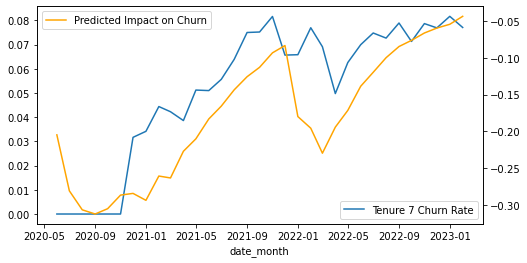

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[7], label= 'Tenure 7 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

## 2. Correlation with Churn changes

In [181]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,10,11,12,genpop_churn,change_in_churn
0,2020-06-01,0.081925,0.416667,0.059701,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.082013,-0.204693
1,2020-07-01,0.147216,0.067450,0.125000,0.030769,0.000000,0.000000,0.0,0.0,0.5,0.0,1.0,0.0,0.144546,-0.280786
2,2020-08-01,0.246896,0.098401,0.061422,0.068966,0.046875,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.150222,-0.306587
3,2020-09-01,0.266349,0.131667,0.073671,0.047285,0.640000,0.949153,0.0,0.0,0.0,0.0,0.0,0.0,0.138151,-0.312278
4,2020-10-01,0.232411,0.143210,0.101009,0.059563,0.040794,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.134923,-0.305047


In [182]:
churn_change_all = churn_all[FEATURE_COLS].diff()

In [184]:
churn_change_all = pd.concat([churn_all[['date_month']], churn_change_all, churn_all[['change_in_churn']] ]
                            , axis = 1)

In [185]:
churn_change_all.head()

,date_month,1,2,3,4,5,6,7,8,9,10,11,12,genpop_churn,change_in_churn
0,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.204693
1,2020-07-01,0.065291,-0.349217,0.065299,0.030769,0.000000,0.000000,0.0,0.0,0.5,0.0,1.0,0.0,0.062533,-0.280786
2,2020-08-01,0.099680,0.030951,-0.063578,0.038197,0.046875,0.000000,0.0,0.0,-0.5,0.0,-1.0,0.0,0.005676,-0.306587
3,2020-09-01,0.019453,0.033266,0.012249,-0.021681,0.593125,0.949153,0.0,0.0,0.0,0.0,0.0,0.0,-0.012071,-0.312278
4,2020-10-01,-0.033938,0.011543,0.027338,0.012278,-0.599206,-0.858244,0.0,0.0,0.0,0.0,0.0,0.0,-0.003228,-0.305047


In [187]:
plot_data=churn_change_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,change_in_churn
dummy_value,-1.000000
1,-0.232743
4,-0.169717
genpop_churn,-0.138811
3,-0.134030
7,-0.132511
12,-0.060373
5,-0.025267
6,-0.023596
10,0.000241


<AxesSubplot:>

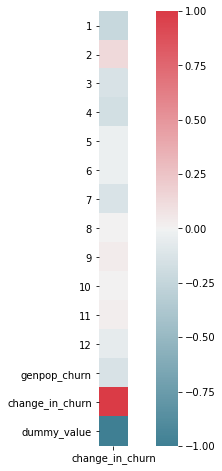

In [188]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

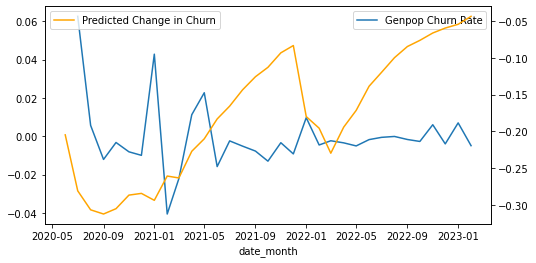

In [189]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_change_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Change in Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend()
ax2.legend()

plt.show()

In [ ]:
churn_exclude_t1

# Write to S3/SF

In [ ]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [ ]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [ ]:
write_to_sf(data, 'daily_monthly_retention_value.csv')

In [273]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format('daily_monthly_retention_value')

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value.csv'